In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import cv2
import warnings
import timeit
import pytorch_lightning as pl
from tqdm.auto import tqdm
from torch import optim
from scipy.special import expit
from skimage import io, transform, measure
from sklearn import metrics
from config import *
from conf_demo import *
from util import *
from models import *
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
rc = {"figure.figsize" : (9, 7),
      "axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "axes.grid" : False}
plt.rcParams.update(rc)


def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    return roc_t['threshold'].item()

def infer_diagnosis(result):
    preds = []
    for idx, row in result.iterrows():
        if (row[mel_class_labels_pred] == 1).sum() > 1:
            preds.append(1)
        else:
            preds.append(0)
    result['prediction'] = preds
    return result
    
def get_thresholds(result):
    thresholds = []
    for col in char_class_labels:
        threshold = find_optimal_cutoff(result[col], result[col+'_score'])
        thresholds.append(threshold)
    thresholds = torch.tensor(thresholds)
    return thresholds

def display_scores(result):
    print('balanced acc: ', metrics.balanced_accuracy_score(result['benign_malignant'], result['prediction']).round(5))
    print('sensitivity: ', metrics.recall_score(result['benign_malignant'], result['prediction']).round(5))
    print('specificity: ', metrics.recall_score(result['benign_malignant'], result['prediction'], pos_label=0).round(5))

In [2]:
%%time
torch.cuda.empty_cache()

model = CharacteristicsClassifier(img_dir=img_dir, annotations_dir=annotations_dir, metadata_file=metadata_file, weighted_sampling=False,
                                  batch_size=batch_size, learning_rate=learning_rate)
trainer = pl.Trainer(max_epochs=num_epochs, devices=1, accelerator="gpu", deterministic=True)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type              | Params
--------------------------------------------------
0 | lossC       | BCEWithLogitsLoss | 0     
1 | lossA       | DiceLoss          | 0     
2 | base_model  | ResNet            | 23.5 M
3 | sigmoid     | Sigmoid           | 0     
4 | accuracy    | Accuracy          | 0     
5 | auroc       | AUROC             | 0     
6 | sensitivity | Recall            | 0     
7 | specificity | Specificity       | 0     
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 35min 35s, sys: 6min 18s, total: 41min 53s
Wall time: 44min 25s


In [4]:
# Val predictions
result_val = get_char_predictions(trainer, model, split='val', threshold=-0.3)
result_val = infer_diagnosis(result_val)
print('Validation:')
display_scores(result_val)
thresholds = get_thresholds(result_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 83it [00:00, ?it/s]

Validation:
balanced acc:  0.82045
sensitivity:  0.77907
specificity:  0.86183


In [5]:
# Test predictions
result_test = get_char_predictions(trainer, model, split='test', threshold=thresholds)
result_test = infer_diagnosis(result_test)
print('Test:')
display_scores(result_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 83it [00:00, ?it/s]

Test:
balanced acc:  0.81
sensitivity:  0.76
specificity:  0.86


In [7]:
def temperature_scale(temperature, logits):
    temp = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return logits / temp

def eval():
    optimizer.zero_grad()
    loss = criterion(temperature_scale(temperature, logits), labels)
    loss.backward()
    return loss

temperature_dict = {}
for i, col in enumerate(char_class_labels):
    labels = torch.tensor(result_val[col].values).float().unsqueeze(0)
    logits = torch.tensor(result_val[col+'_score'].values).float().unsqueeze(0)
    criterion = nn.BCEWithLogitsLoss()
    #before_temperature_ce = criterion(logits, labels)
    
    temperature = nn.Parameter(torch.ones(1) * 1.5)
    optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=50)

    optimizer.step(eval)
    
    temperature_dict[char_labels_full[i]] = temperature.item()

# Working Example
### Set the image_id variable. Some images are provided in the images directory. 
### Run the following cell to display the image.
### Run the cell after that to display the explanations for the image.

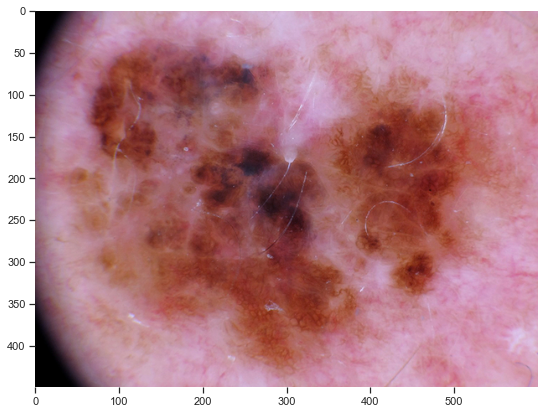

In [8]:
IMAGE_ID = 'ISIC_0026086'

raw_img = io.imread(os.path.join('images', IMAGE_ID+'.jpg'))
plt.imshow(raw_img)

ISIC_0026086
CPU times: user 3.66 s, sys: 28.2 ms, total: 3.69 s
Wall time: 3.68 s


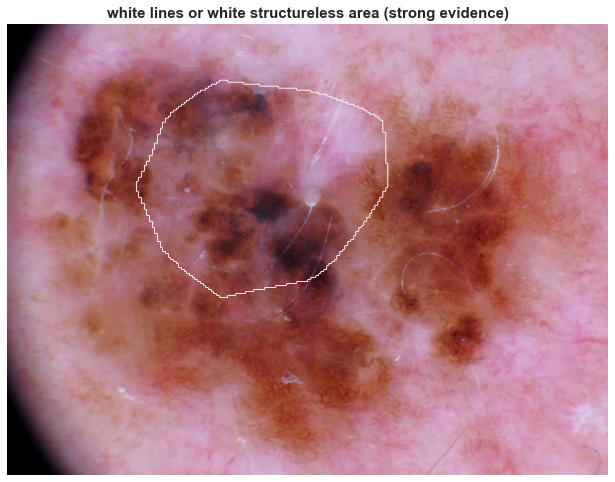

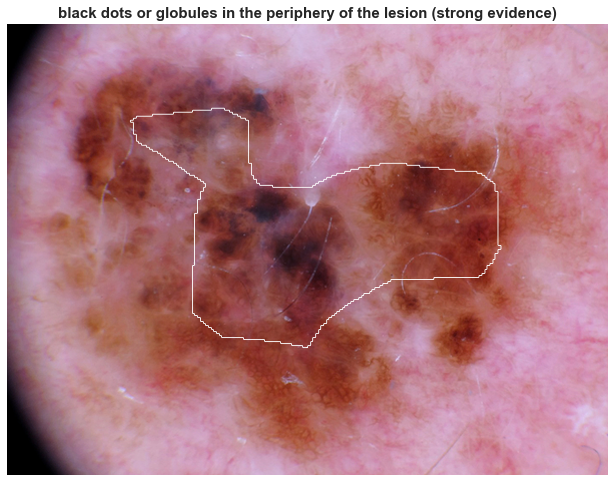

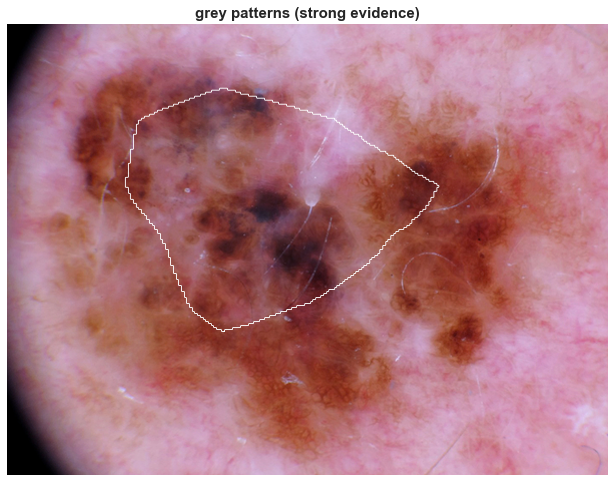

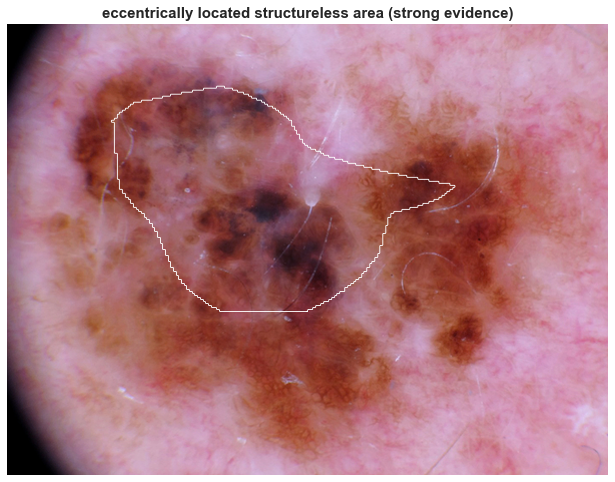

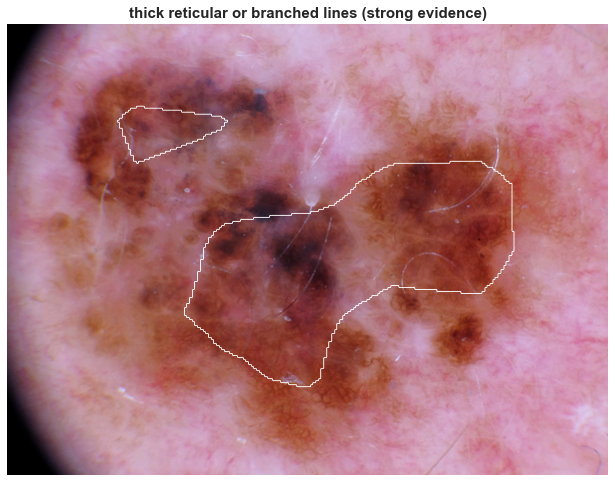

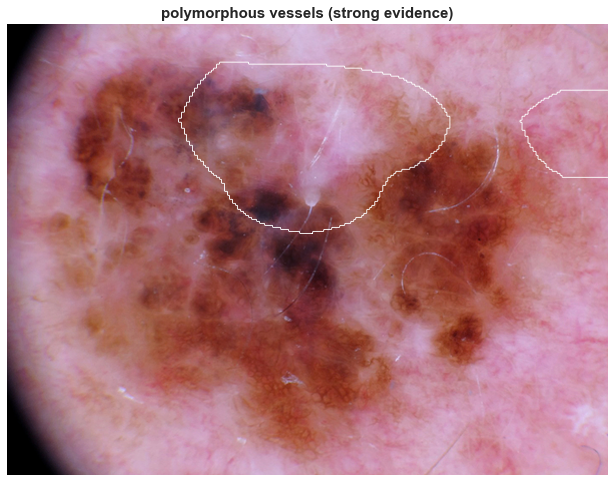

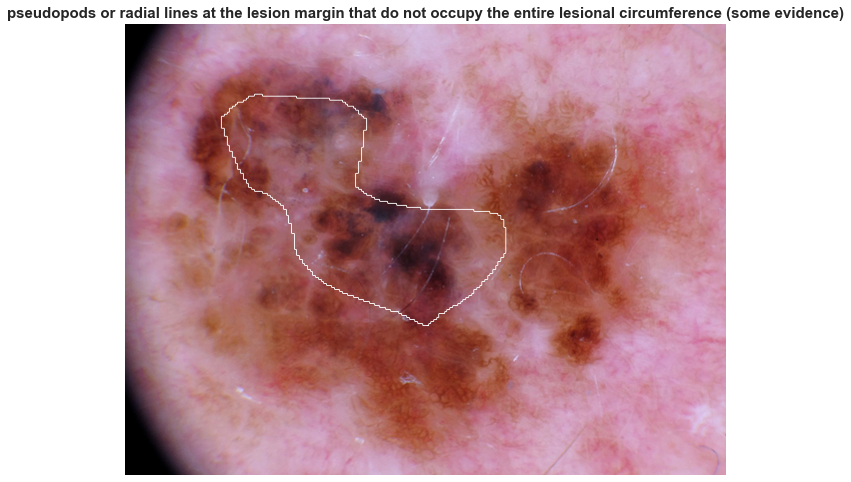

In [9]:
%%time
def forward(x):
    output = model.base_model(x)
    attributions = torch.cat([model.attribute(output, class_idx) for class_idx in range(model.num_classes)], dim=1)
    attributions = F.interpolate(attributions, size=(image_size, image_size), mode='bilinear')
    return output, attributions
    
prediction_dfs = []
result_test = pd.DataFrame({'image_id': [IMAGE_ID]})
for idx, row in result_test.iterrows():
    # Read the image
    raw_img = io.imread(os.path.join(img_dir, row.image_id+'.jpg'))
    # Transform the image (resize, normalize) and get prediction and attributions
    img = model.test_transform(image=raw_img, mask=raw_img)['image'].unsqueeze(0)
    output, attributions = forward(img)

    # Change the shapes of the attributions and logits tensors
    attributions = attributions.squeeze(0).detach().numpy()
    output = output.squeeze(0)
    # Get binary array of predicted labels for the current image
    prediction = (output >= thresholds).numpy()
    
    prediction_df = pd.DataFrame(zip(char_labels_full, prediction, output.detach().numpy()), columns=['label', 'prediction', 'output'])#[prediction]
    prediction_df['image_id'] = row.image_id
    prediction_df = prediction_df[prediction_df['prediction'] == True]
    # Temp scale and apply sigmoid
    prediction_df['output'] = prediction_df.apply(lambda row: expit(
        row['output'] / temperature_dict[row['label']]
    ), axis=1)
    
    # Calculate confidence defined by percentiles
    prediction_df['confidence'] = prediction_df.apply(lambda row: 'strong' if row['output'] >= 0.7
                                                      else ('low' if row['output']<0.5
                                                           else 'some'), axis=1)
    #prediction_df.sort_values('confidence', ascending=False, inplace=True)
    prediction_df.sort_values('output', ascending=False, inplace=True)
    
    prediction_dfs.append(prediction_df)
    
    for i in range(prediction_df.shape[0]):
        # Resize the unnormalized image for plotting
        image = transform.resize(raw_img, (450, 600))
        
        exp = prediction_df.iloc[i].label
        attr_idx = prediction_df.iloc[i].name
        conf = prediction_df.iloc[i].confidence
                
        attr_non_zero = attributions[attr_idx][attributions[attr_idx]>0.]
        if len(attr_non_zero) == 0:
            perc = 0
        else:
            perc = (np.percentile(attr_non_zero, 80))
        attr = (attributions[attr_idx] >= perc)

        attr = transform.resize(attr, (450, 600))


        image = np.clip(image, 0, 1)
        contours = measure.find_contours(attr)
        
        fig, ax = plt.subplots()
        ax.imshow(image)

        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=0.9, color='white')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(exp+" ("+str(conf)+" evidence)", fontsize=15, fontweight='bold', loc='center', wrap=True)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)

        #plt.clf()
        #plt.close(fig)        
    print(row.image_id)
prediction_df_all = pd.concat(prediction_dfs)